In [2]:
#supress warnings (especially from sklearn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, roc_curve, auc, precision_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import csv
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from scipy import interp

%matplotlib inline

<h2> Preprocessing </h2>

patient_ccs_100.csv contains the clusters (k=3) of patients after running k-modes. First, we merge the cluster information in with all the feature data. Then, we merge the readmission labels with the data to preserve the true labels. Then, we drop the CCS_codes field and the ICD9_codes fields because they are irrelevant past the clustering analysis. We then save this data to a csv file. We also drop the subject_id and hadm_id because they are also not relevant in developing models for the data. We then save this version of the data as well. 

In [4]:
ccs_data = pd.read_csv('../data/patient_ccs_100.csv')
ccs_data = ccs_data.rename(index=str, columns={"SUBJECT_ID": "subject_id", "HADM_ID": "hadm_id"})
all_data = pd.read_csv('../data/x_with_lacefeatures.csv')
labels = pd.read_csv('../data/y_more_no_df_clean.csv')
merged_data = all_data.merge(ccs_data, on=['subject_id', 'hadm_id'])
labeled_data = merged_data.join(labels)
labeled_data = labeled_data.drop(['CCS_codes', 'ICD9_CODES'], axis=1)
labeled_data.to_csv('../data/labeled_clustered_data_with_ids.csv')
save_labeled_data = labeled_data.drop(['subject_id', 'hadm_id'], axis=1)
save_labeled_data.to_csv('../data/labeled_clustered_data.csv')

<h3>Clusters by gender</h3>

Each cluster is shows the Male and Female Distribution within that cluster

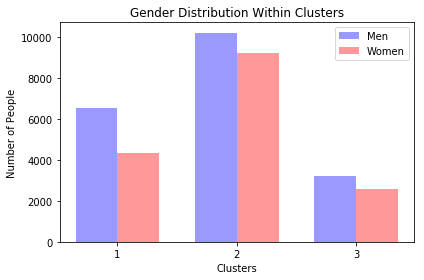

In [132]:
cluster_readmission = labeled_data.groupby(['cluster_num','gender_M']).size()
means_men = []
means_women = []
n_groups = int(len(cluster_readmission)/2)
for i in range(n_groups):
    means_men.append(cluster_readmission[i][1])
    means_women.append(cluster_readmission[i][0])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,
                alpha=opacity, color='b',
                 error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width,
                alpha=opacity, color='r',
                 error_kw=error_config,
                label='Women')

ax.set_xlabel('Clusters')
ax.set_ylabel('Number of People')
ax.set_title('Gender Distribution Within Clusters')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3'))
ax.legend()

fig.tight_layout()
plt.show()

<h3>Urea mean within cluster</h3>

Each cluster displays the average urea_n_mean.

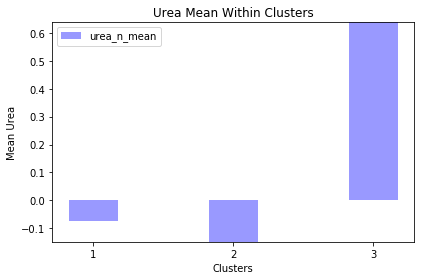

In [167]:
cluster_readmission = labeled_data.groupby(['cluster_num']).mean()
urea_mean = []
n_groups = int(len(cluster_readmission))
for i in range(n_groups):
    urea_mean.append(cluster_readmission['urea_n_mean'][i])
    
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index +.175, urea_mean, bar_width,
                alpha=opacity, color='b',
                 error_kw=error_config,
                label='urea_n_mean')
ax.set_ylim((min(urea_mean), max(urea_mean)))
ax.set_xlabel('Clusters')
ax.set_ylabel('Mean Urea')
ax.set_title('Urea Mean Within Clusters')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3'))
ax.legend()

fig.tight_layout()
plt.show()

<h3>Average Length of Stay per Cluster</h3>


[4.785898143041, 4.948066013408973, 5.308195592286501]


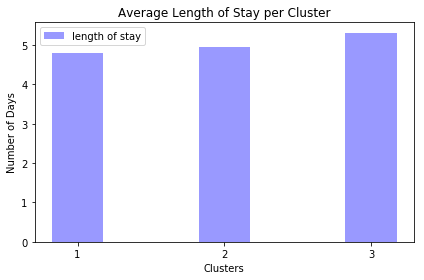

In [157]:
cluster_readmission = labeled_data.groupby(['cluster_num']).mean()
length_stay = []
n_groups = int(len(cluster_readmission))
for i in range(n_groups):
    length_stay.append(cluster_readmission['length_stay'][i])

print(length_stay)
    
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index+.175, length_stay, bar_width,
                alpha=opacity, color='b',
                 error_kw=error_config,
                label='length of stay')
# ax.set_ylim(0, max(length_stay))
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of Days')
ax.set_title('Average Length of Stay per Cluster')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3'))
ax.legend()

fig.tight_layout()
plt.show()

<h3>diastolic blood pressure</h3>

[-0.2117290886711713, 0.22913543418700355, -0.3684137469834707]


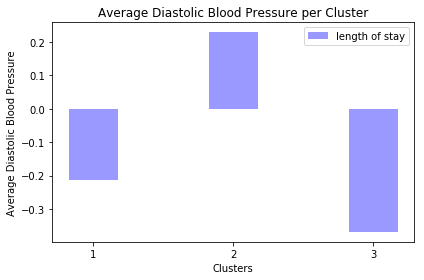

In [166]:
cluster_readmission = labeled_data.groupby(['cluster_num']).mean()
diasbp_mean = []
n_groups = int(len(cluster_readmission))
for i in range(n_groups):
    diasbp_mean.append(cluster_readmission['diasbp_mean'][i])

print(diasbp_mean)
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index+.175, diasbp_mean, bar_width,
                alpha=opacity, color='b',
                 error_kw=error_config,
                label='length of stay')
ax.set_xlabel('Clusters')
ax.set_ylabel('Average Diastolic Blood Pressure')
ax.set_title('Average Diastolic Blood Pressure per Cluster')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('1', '2', '3'))
ax.legend()

fig.tight_layout()
plt.show()

<h3> Systolic Blood Pressure</h3>

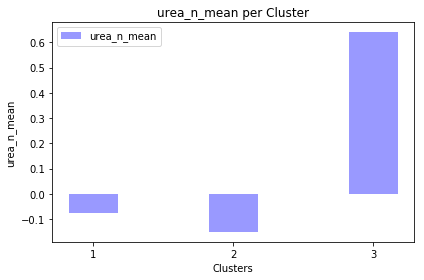

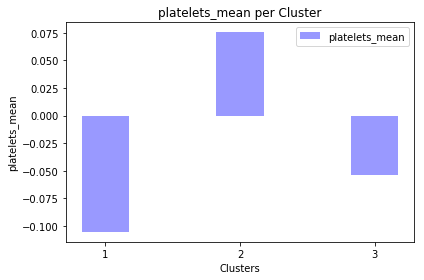

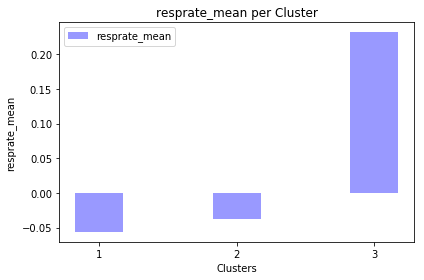

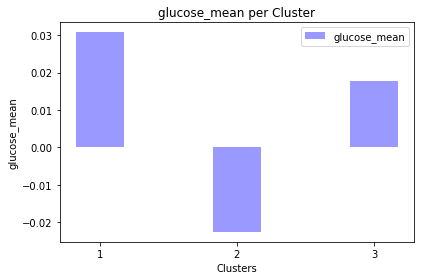

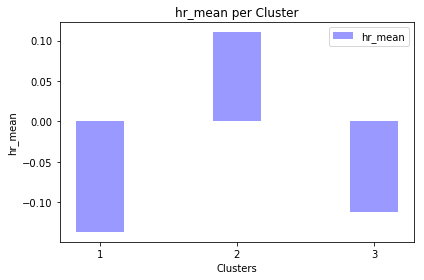

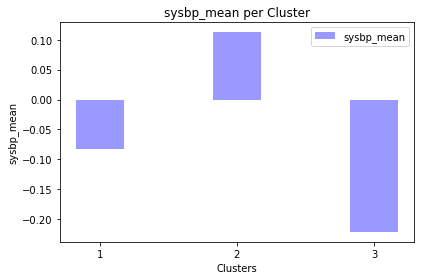

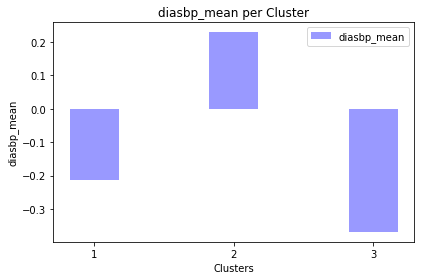

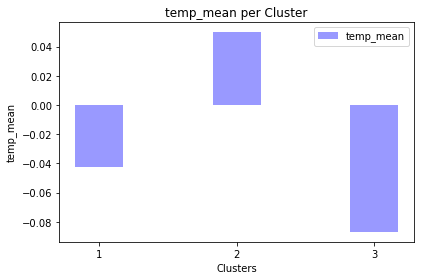

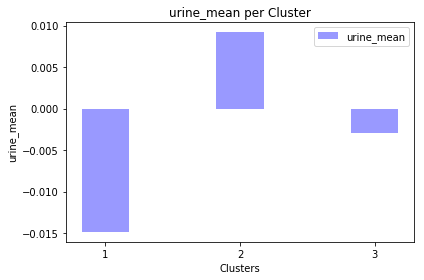

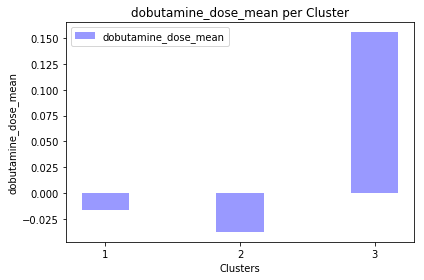

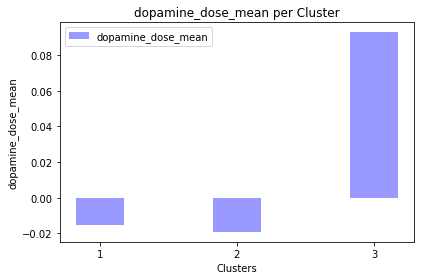

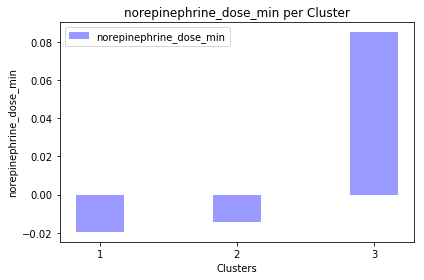

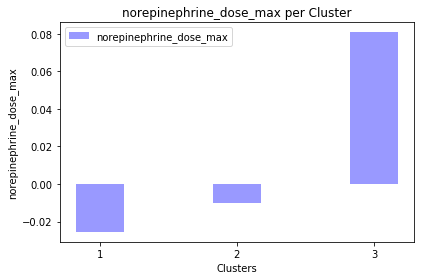

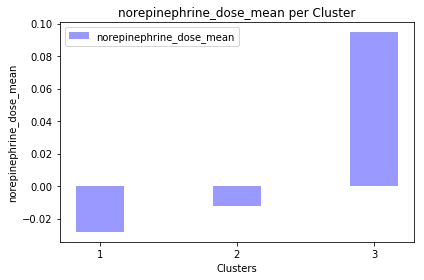

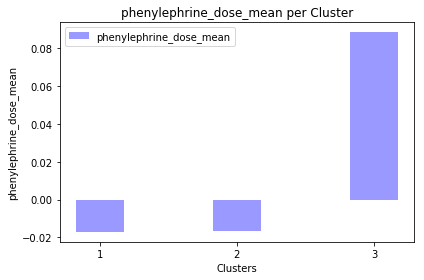

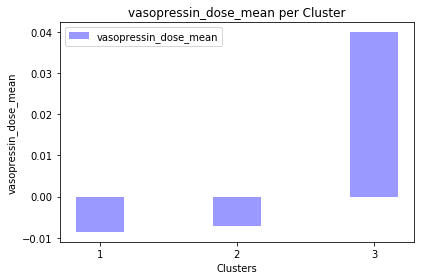

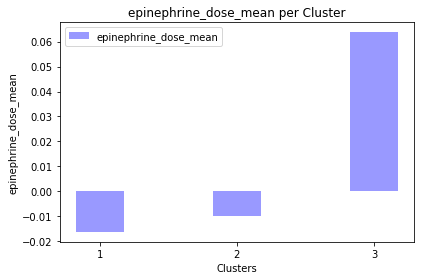

In [13]:
from os import path

# print(list(labeled_data))
features = ['urea_n_mean', 'platelets_mean','resprate_mean', 'glucose_mean','hr_mean','sysbp_mean','diasbp_mean','temp_mean','urine_mean', 'dobutamine_dose_mean','dopamine_dose_mean', 'norepinephrine_dose_min', 'norepinephrine_dose_max', 'norepinephrine_dose_mean','phenylephrine_dose_mean', 'vasopressin_dose_mean', 'epinephrine_dose_mean']
cluster_readmission = labeled_data.groupby(['cluster_num']).mean()
n_groups = int(len(cluster_readmission))
for feature in features:
    mean = []
    for i in range(n_groups):
        mean.append(cluster_readmission[feature][i])

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index+.175, mean, bar_width,
                    alpha=opacity, color='b',
                     error_kw=error_config,
                    label=feature)
    ax.set_xlabel('Clusters')
    ax.set_ylabel(feature)
    ax.set_title(feature + ' per Cluster')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('1', '2', '3'))
    ax.legend()

    fig.tight_layout()
    plt.savefig(path.join("cluster_features",feature + ".png"))
    plt.show()
#     plt.savefig("cluster_features/" + feature + ".png")
    plt.clf()